In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import datetime
import os
from sklearn import metrics
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup

MODEL_PATH = 'model_save'
TRAIN_PATH = '/kaggle/input/messages/train_spam.csv'
TEST_PATH = '/kaggle/input/messages/test_spam.csv'
MAX_LEN = 128
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

2024-05-03 00:07:56.545848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 00:07:56.545925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 00:07:56.547788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv(TRAIN_PATH)
data=df.copy()

In [3]:
sentences = data.text.values
labels = [0 if x == 'ham' else 1 for x in data.text_type.values]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
input_ids = [tokenizer.encode(x, add_special_tokens = True) for x in sentences]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN , truncating="post", padding="post")
attention_masks = [[int(y > 0) for y in x] for x in input_ids]

Token indices sequence length is longer than the specified maximum sequence length for this model (965 > 512). Running this sequence through the model will result in indexing errors


In [4]:
train_inputs = torch.tensor(input_ids)
train_labels = torch.tensor(labels)
train_masks = torch.tensor(attention_masks)
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
val_train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_train_dataloader = DataLoader(train_data, sampler=val_train_sampler, batch_size=batch_size)

In [5]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [16]:
format_time = lambda elapsed: str(datetime.timedelta(seconds=int(round((elapsed)))))
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)            
    print("")
    print("  Average training loss: {0:.5f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
    print("")
    model.eval()
print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    509.    Elapsed: 0:00:25.
  Batch    80  of    509.    Elapsed: 0:00:50.
  Batch   120  of    509.    Elapsed: 0:01:14.
  Batch   160  of    509.    Elapsed: 0:01:39.
  Batch   200  of    509.    Elapsed: 0:02:04.
  Batch   240  of    509.    Elapsed: 0:02:29.
  Batch   280  of    509.    Elapsed: 0:02:53.
  Batch   320  of    509.    Elapsed: 0:03:18.
  Batch   360  of    509.    Elapsed: 0:03:43.
  Batch   400  of    509.    Elapsed: 0:04:08.
  Batch   440  of    509.    Elapsed: 0:04:33.
  Batch   480  of    509.    Elapsed: 0:04:57.

  Average training loss: 0.00229
  Training epoch took: 0:05:15


======== Epoch 2 / 4 ========
Training...
  Batch    40  of    509.    Elapsed: 0:00:25.
  Batch    80  of    509.    Elapsed: 0:00:50.
  Batch   120  of    509.    Elapsed: 0:01:14.
  Batch   160  of    509.    Elapsed: 0:01:39.
  Batch   200  of    509.    Elapsed: 0:02:04.
  Batch   240  of    509.    Elapsed: 0:02:29.
  

In [17]:
model_to_save = model.module if hasattr(model, MODEL_PATH) else model 
model_to_save.save_pretrained(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)

('model_save/tokenizer_config.json',
 'model_save/special_tokens_map.json',
 'model_save/vocab.txt',
 'model_save/added_tokens.json')

In [6]:
model = model.from_pretrained(MODEL_PATH)
tokenizer = tokenizer.from_pretrained(MODEL_PATH)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [18]:
train_predictions = []
for batch in val_train_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, _ = batch
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        train_predictions+=list(np.argmax(logits, axis=1).flatten())


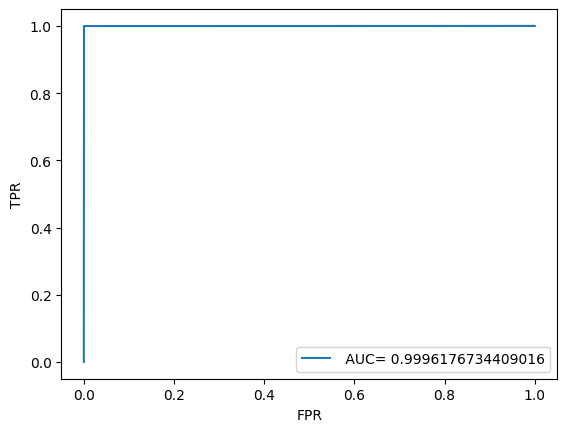

AUC=0.9996176734409016


In [21]:
fpr, tpr, _ = metrics.roc_curve(labels, train_predictions)
auc = metrics.roc_auc_score(labels, train_predictions)
plt.plot(fpr,tpr,label = " AUC= " + str(auc))
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(loc=4)
plt.savefig('ROC-AUC.png')
plt.show()
print('AUC=' + str(auc))

In [22]:
tdf = pd.read_csv(TEST_PATH)
test_data=tdf.copy()
test_sentences = test_data.text.values
test_input_ids = [tokenizer.encode(x, add_special_tokens = True) for x in test_sentences]
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN , truncating="post", padding="post")
test_attention_masks = [[int(y > 0) for y in x] for x in test_input_ids]
test_prediction_inputs = torch.tensor(test_input_ids)
test_prediction_masks = torch.tensor(test_attention_masks)
prediction_data = TensorDataset(test_prediction_inputs, test_prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
test_predictions = []
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    test_predictions+=list(np.argmax(logits, axis=1).flatten())
test_predictions = ['ham' if x==0 else 'spam' for x in test_predictions]

In [23]:
test_predictions_file = pd.DataFrame(
    {'score': test_predictions,
     'text': test_sentences
    })
test_predictions_file.to_csv('predicted_test_spam.csv', index=False)